In this notebook we train a RealNVP based flow model to approximate the Double Well Boltzmann Distribution.
Scroll down to the bottom for visualisation of results. 

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import normflow as nf
import matplotlib.pyplot as plt
import torch

from fab import FABModel, HamiltoneanMonteCarlo, Trainer, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair

## Configure Training

In [55]:
dim: int = 2
n_intermediate_distributions: int = 2
layer_nodes_per_dim = 5
batch_size: int = 128
n_iterations: int = 1500
n_plots: int = 5 # number of plots shows throughout tranining
lr: float = 1e-3
transition_operator_type: str = "hmc"  # "metropolis" or "hmc"
seed: int = 0
n_flow_layers: int = 10
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

## Setup Double Well target distribution

In [56]:
from fab.target_distributions import ManyWellEnergy
assert dim % 2 == 0
target = ManyWellEnergy(dim, a=-0.5, b=-6)
plotting_bounds = (-3, 3)

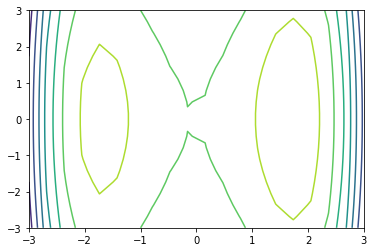

In [57]:
# plot target
plot_contours(target.log_prob, bounds=plotting_bounds)

## Setup Flow
By wrapping the [normflow library](https://github.com/VincentStimper/normalizing-flows). 

In [58]:
from fab.wrappers.normflow import WrappedNormFlowModel
from fab.trainable_distributions import TrainableDistribution


def make_normflow_flow(dim: int,
                       n_flow_layers: int,
                       layer_nodes_per_dim: int,
                       act_norm: bool):
    # Define list of flows
    flows = []
    layer_width = dim * layer_nodes_per_dim
    for i in range(n_flow_layers):
        # Neural network with two hidden layers having 32 units each
        # Last layer is initialized by zeros making training more stable
        param_map = nf.nets.MLP([int((dim / 2) + 0.5), layer_width, layer_width, dim], init_zeros=True)
        # Add flow layer
        flows.append(nf.flows.AffineCouplingBlock(param_map, scale_map="exp"))
        # Swap dimensions
        flows.append(nf.flows.Permute(dim, mode='swap'))
        # ActNorm
        if act_norm:
            flows.append(nf.flows.ActNorm(dim))
    return flows


def make_wrapped_normflowdist(
        dim: int,
        n_flow_layers: int = 5,
        layer_nodes_per_dim: int = 10,
        act_norm: bool = False) -> TrainableDistribution:
    """Created a wrapped Normflow distribution using the example from the normflow page."""
    base = nf.distributions.base.DiagGaussian(dim)
    flows = make_normflow_flow(dim, n_flow_layers=n_flow_layers,
                               layer_nodes_per_dim=layer_nodes_per_dim,
                               act_norm=act_norm)
    model = nf.NormalizingFlow(base, flows)
    wrapped_dist = WrappedNormFlowModel(model)
    return wrapped_dist

In [59]:
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim)

## Setup transition operator

In [60]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError

## Define model, trainer and plotter

In [61]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger() # save training history

using linear spacing as there are only 2 intermediate distribution


In [62]:
def plot(fab_model, n_samples = 300):
    fig, axs = plt.subplots(1, 2)

    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0])
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1])

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0]
    plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
    axs[0].set_title("flow samples")
    axs[1].set_title("ais samples")
    plt.show()

In [63]:
# Create trainer
trainer = Trainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler)

# Run with visualisation

loss: 12.637451792951689:   0%|                                                                                                                                                                       | 0/1500 [00:00<?, ?it/s]

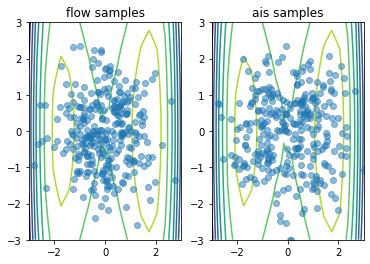

loss: 11.301460730016368:  25%|███████████████████████████████████████                                                                                                                      | 373/1500 [00:32<01:29, 12.54it/s]

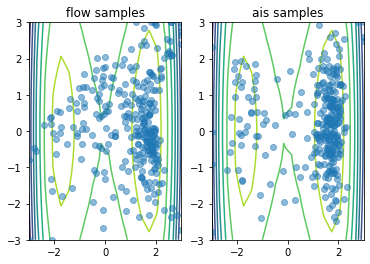

loss: 10.903673653920567:  33%|███████████████████████████████████████████████████▍                                                                                                         | 491/1500 [00:42<01:20, 12.49it/s]

1 nan/inf weights


loss: 10.770316227102919:  35%|██████████████████████████████████████████████████████▋                                                                                                      | 523/1500 [00:44<01:22, 11.83it/s]

1 nan/inf weights


loss: 10.737276858098031:  35%|██████████████████████████████████████████████████████▉                                                                                                      | 525/1500 [00:44<01:24, 11.54it/s]

1 nan/inf weights


loss: 10.764062428678422:  37%|█████████████████████████████████████████████████████████▌                                                                                                   | 550/1500 [00:47<01:18, 12.07it/s]

1 nan/inf weights


loss: 10.706892609860482:  38%|███████████████████████████████████████████████████████████▋                                                                                                 | 570/1500 [00:49<01:21, 11.41it/s]

1 nan/inf weights


loss: 10.765015760166921:  39%|████████████████████████████████████████████████████████████▋                                                                                                | 580/1500 [00:49<01:19, 11.52it/s]

1 nan/inf weights


loss: 10.768079874928656:  40%|██████████████████████████████████████████████████████████████▌                                                                                              | 598/1500 [00:51<01:16, 11.81it/s]

1 nan/inf weights


loss: 10.692257646594252:  40%|███████████████████████████████████████████████████████████████▏                                                                                             | 604/1500 [00:52<01:16, 11.64it/s]

1 nan/inf weights


loss: 10.72713311633871:  42%|██████████████████████████████████████████████████████████████████▏                                                                                           | 628/1500 [00:53<01:14, 11.77it/s]

1 nan/inf weights


loss: 10.871310640513963:  43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 640/1500 [00:55<01:14, 11.51it/s]

1 nan/inf weights
1 nan/inf weights


loss: 10.610848438847054:  44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 656/1500 [00:56<01:10, 11.96it/s]

1 nan/inf weights


loss: 10.65848551478415:  45%|██████████████████████████████████████████████████████████████████████▊                                                                                       | 672/1500 [00:57<01:09, 11.87it/s]

1 nan/inf weights
2 nan/inf weights


loss: 10.69099543429888:  46%|████████████████████████████████████████████████████████████████████████▍                                                                                     | 688/1500 [00:59<01:08, 11.79it/s]

1 nan/inf weights
1 nan/inf weights


loss: 10.711414115718448:  47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 698/1500 [00:59<01:05, 12.22it/s]

1 nan/inf weights


loss: 10.645072779332772:  47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 706/1500 [01:00<01:07, 11.69it/s]

1 nan/inf weights
1 nan/inf weights


loss: 10.709782215082235:  48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 718/1500 [01:01<01:07, 11.51it/s]

1 nan/inf weights


loss: 10.597164276198367:  48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 724/1500 [01:02<01:06, 11.60it/s]

1 nan/inf weights


loss: 10.82670039548168:  49%|█████████████████████████████████████████████████████████████████████████████                                                                                 | 732/1500 [01:02<01:09, 11.05it/s]

1 nan/inf weights
1 nan/inf weights


loss: 10.612124092182158:  50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 748/1500 [01:04<01:05, 11.52it/s]

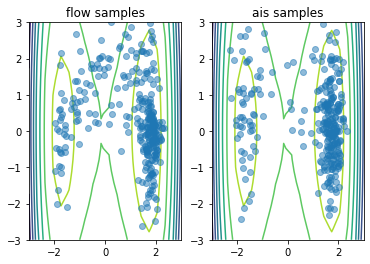

loss: 10.650889768988932:  51%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 758/1500 [01:05<01:10, 10.49it/s]

1 nan/inf weights


loss: 10.597106755296398:  51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 772/1500 [01:06<01:00, 12.03it/s]

1 nan/inf weights


loss: 10.683994065870301:  52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 778/1500 [01:07<00:58, 12.31it/s]

1 nan/inf weights


loss: 10.773624191212111:  52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 782/1500 [01:07<01:02, 11.43it/s]

1 nan/inf weights


loss: 10.580427599763304:  53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 790/1500 [01:08<01:01, 11.49it/s]

1 nan/inf weights


loss: 10.635743317447652:  53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 796/1500 [01:08<01:08, 10.29it/s]

1 nan/inf weights


loss: 10.54912246967136:  54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 812/1500 [01:10<00:56, 12.19it/s]

1 nan/inf weights


loss: 10.537448123483655:  56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 834/1500 [01:11<00:54, 12.13it/s]

1 nan/inf weights


loss: 10.552839113762598:  57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 850/1500 [01:13<00:52, 12.46it/s]

1 nan/inf weights


loss: 10.606047075408888:  58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 864/1500 [01:14<00:53, 11.90it/s]

1 nan/inf weights


loss: 10.763096605099298:  59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 892/1500 [01:16<01:23,  7.29it/s]

1 nan/inf weights


loss: 10.501868925998965:  60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 898/1500 [01:17<01:05,  9.13it/s]

1 nan/inf weights


loss: 10.950607287613156:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 932/1500 [01:20<00:46, 12.23it/s]

1 nan/inf weights


loss: 10.54062988620072:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 942/1500 [01:21<00:48, 11.47it/s]

1 nan/inf weights
1 nan/inf weights


loss: 10.502009916674794:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1052/1500 [01:30<00:38, 11.50it/s]

1 nan/inf weights


loss: 10.487064238115536:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1088/1500 [01:33<00:33, 12.19it/s]

1 nan/inf weights


loss: 10.413307900889858:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1124/1500 [01:36<00:30, 12.41it/s]

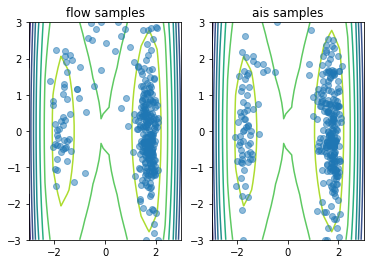

loss: 10.423606574968256: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1499/1500 [02:08<00:00, 11.67it/s]

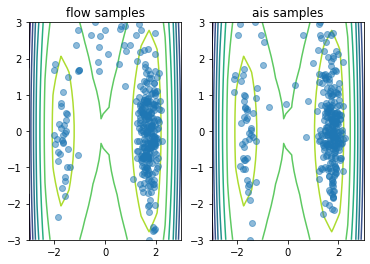

loss: 10.423606574968256: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:08<00:00, 11.66it/s]


In [64]:
# the nan's that arrise during the training are typically from nan flow samples, 
# but in the long term they do not break training. 
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots)

In the below plot:
ess = effective sample size
"Distance" refers to the distance moved during each intermediate transition. 

NaN encountered in ess_ais history
NaN encountered in log_Z history


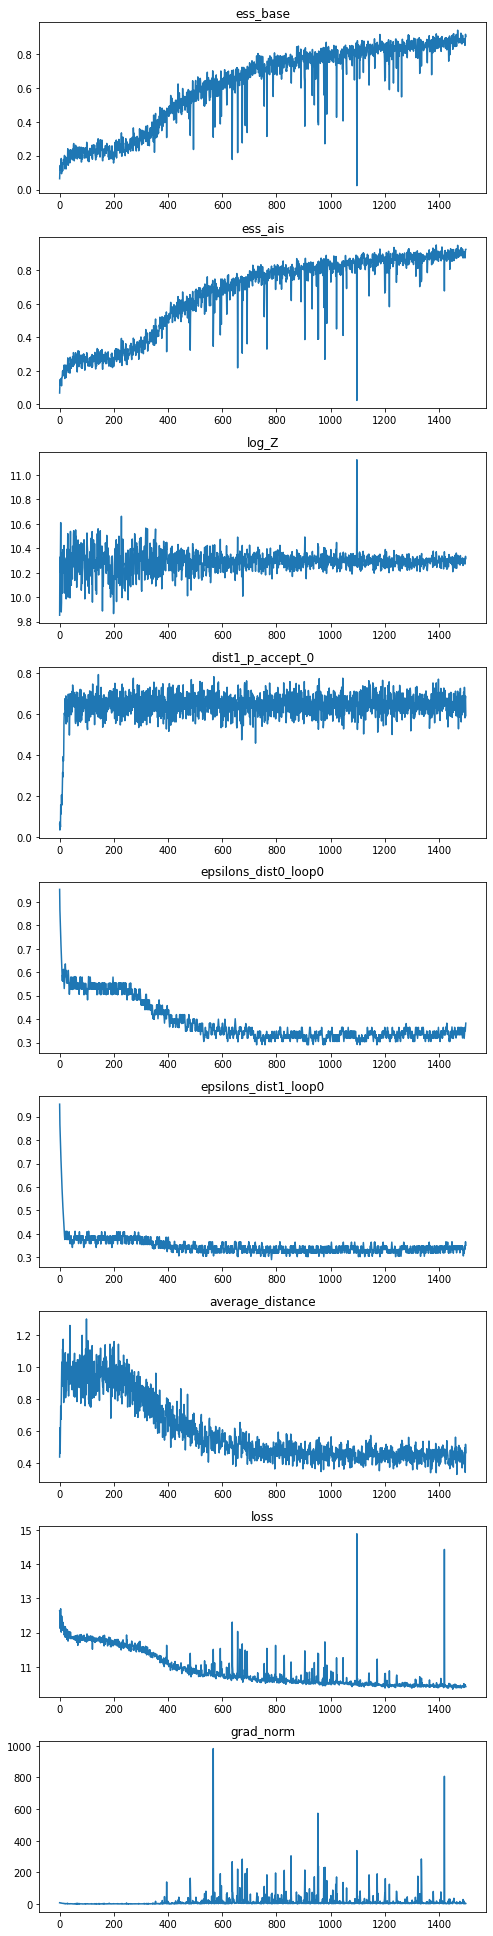

In [65]:
plot_history(logger.history)

## Visualise Trained Flow Model

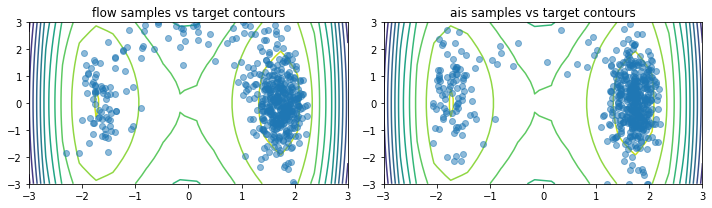

In [66]:
# plot samples on top of contours
n_samples = 500
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=10)
plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=10)
# plot flow samples
samples_flow = fab_model.flow.sample((n_samples,))
plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)
axs[0].set_title("flow samples vs target contours")
# plot ais samples
samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                           logging=False)[0]
plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
axs[1].set_title("ais samples vs target contours")
plt.tight_layout()